## DNN

### libraries

In [1]:
import matplotlib.pyplot as plt

from keras import Sequential
from keras.layers import Dense, Dropout

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

from modules.helpers import load_data

In [2]:
(train_x, train_y), (val_x, val_y), (test_x, test_y) = load_data('dnn')

### model building

In [3]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(train_x.shape[1],)),
    Dropout(0.2),  
    Dense(64, activation='relu'),  
    Dropout(0.2),  
    Dense(32, activation='relu'),  
    Dropout(0.2),
    Dense(1, activation='sigmoid') 
])

2024-04-25 17:01:35.159774: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-04-25 17:01:35.159822: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-04-25 17:01:35.159834: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-04-25 17:01:35.160134: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-25 17:01:35.160352: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [5]:
model.fit(train_x,
          train_y,
          epochs=20, 
          validation_data=(val_x, val_y))

Epoch 1/20


2024-04-25 17:01:35.503732: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-04-25 17:01:35.732713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1414/1414 [==============================] - ETA: 0s - loss: 0.7455 - accuracy: 0.6647

2024-04-25 17:01:44.063266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1414/1414 [==============================] - 10s 6ms/step - loss: 0.7455 - accuracy: 0.6647 - val_loss: 0.6307 - val_accuracy: 0.7048
Epoch 2/20
1414/1414 [==============================] - 9s 6ms/step - loss: 0.6439 - accuracy: 0.6999 - val_loss: 0.6150 - val_accuracy: 0.7362
Epoch 3/20
1414/1414 [==============================] - 9s 6ms/step - loss: 0.6704 - accuracy: 0.6988 - val_loss: 0.6813 - val_accuracy: 0.7056
Epoch 4/20
1414/1414 [==============================] - 9s 6ms/step - loss: 0.6321 - accuracy: 0.7042 - val_loss: 0.7967 - val_accuracy: 0.6656
Epoch 5/20
1414/1414 [==============================] - 9s 6ms/step - loss: 0.6222 - accuracy: 0.7069 - val_loss: 0.6423 - val_accuracy: 0.6925
Epoch 6/20
1414/1414 [==============================] - 9s 6ms/step - loss: 0.5918 - accuracy: 0.7132 - val_loss: 0.6639 - val_accuracy: 0.6912
Epoch 7/20
1414/1414 [==============================] - 9s 7ms/step - loss: 0.5780 - accuracy: 0.7187 - val_loss: 0.6440 - val_accuracy: 0.6960
Ep

In [6]:
test_loss, test_acc = model.evaluate(test_x, test_y)
print("Testing loss:", test_loss)
print("Testing accuracy:", test_acc)

442/442 [==============================] - 2s 3ms/step - loss: 0.5199 - accuracy: 0.7419
Testing loss: 0.5199482440948486
Testing accuracy: 0.7419195175170898


In [7]:
y_pred = (model.predict(test_x) > 0.5).astype(int)

119/442 [=======>......................] - ETA: 0s

2024-04-25 17:04:39.575029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


442/442 [==============================] - 1s 1ms/step


Confusion Matrix:


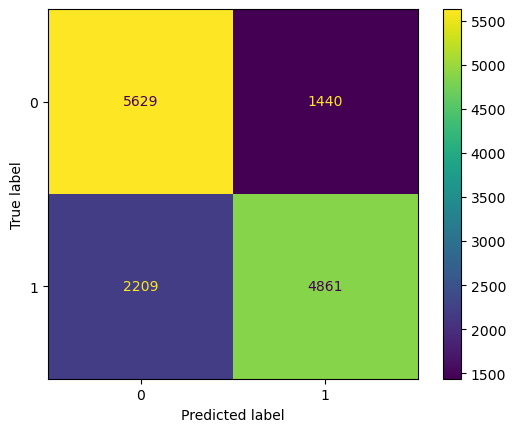

In [8]:
cm = confusion_matrix(test_y, y_pred)
print("Confusion Matrix:")
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [9]:
print("Classification Report:")
print(classification_report(test_y, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.80      0.76      7069
           1       0.77      0.69      0.73      7070

    accuracy                           0.74     14139
   macro avg       0.74      0.74      0.74     14139
weighted avg       0.74      0.74      0.74     14139

